In [1]:
import os
import json
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
sns.set_style("ticks")
sns.set_context("paper")

## Loading Results

In [3]:
# save_dir = "outputs/gcbc_eval/GCBC-CALVIN-s1"
save_dir = "../outputs/gcbc_eval/GCBC-CALVIN-s1"

In [4]:
results_path = os.path.join(save_dir, "results.npz")
results = dict(**np.load(results_path))
evaluated_idxs_path = os.path.join(save_dir, "evaluated_idxs.npz")
evaluated_idxs = dict(**np.load(evaluated_idxs_path))
videos_path = os.path.join(save_dir, "videos.npz")
videos = dict(**np.load(videos_path))
videos_metadata_path = os.path.join(save_dir, "videos_metadata.json")
with open(videos_metadata_path, 'r') as f:
    videos_metadata = json.load(f)

In [5]:
tasks = list(results.keys())

## Success Rate

In [6]:
success_rates = {k: v.sum() / v.size for k, v in results.items()}
total_sr = sum([v.sum() for v in results.values()]) / sum(
    [len(v) for v in results.values()]
)

### Main

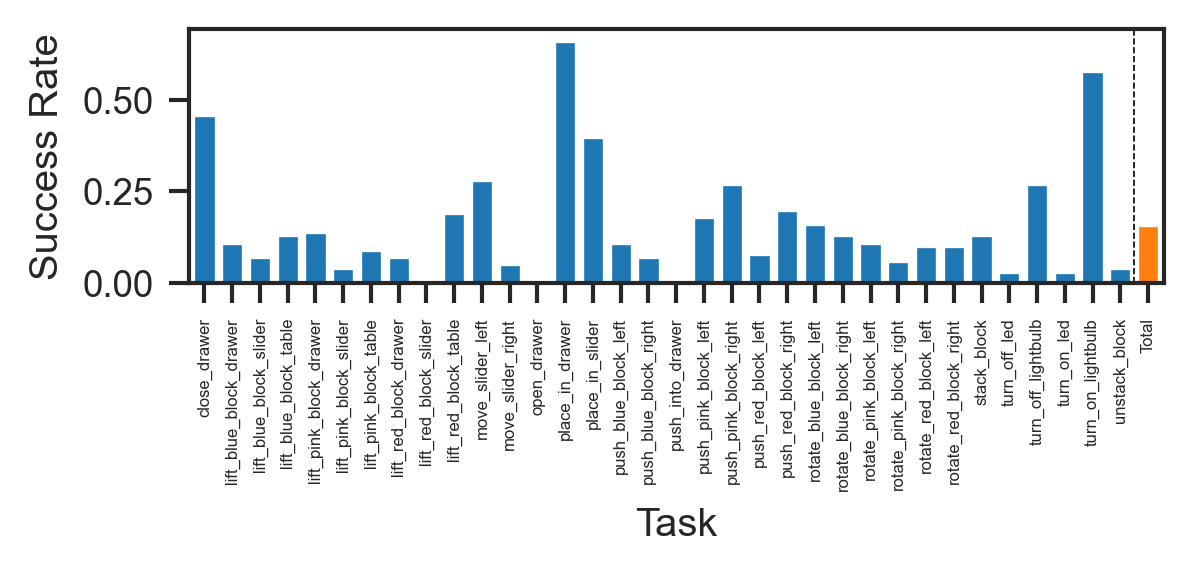

In [7]:
f, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=300)

# ax.bar(*zip(*success_rates.items()))
# sns.barplot(x=success_rates.keys(), y=success_rates.values(), ax=ax)
ax.bar(x=tasks, height=[success_rates[task] for task in tasks])
ax.bar(x='Total', height=total_sr)
ax.axvline(x=len(tasks)-0.5, color='black', linestyle='dashed', linewidth=0.4)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=4)

ax.set_ylabel('Success Rate')
ax.set_xlabel('Task')

ax.margins(x=0.005)

f.set_tight_layout(True)
plt.show()

In [8]:
sr_df = pd.DataFrame.from_records(success_rates, index=['Success Rate'])
sr_stats = sr_df.T.describe()
sr_df['Total'] = [total_sr]

In [9]:
sr_df

,close_drawer,lift_blue_block_drawer,lift_blue_block_slider,lift_blue_block_table,lift_pink_block_drawer,lift_pink_block_slider,lift_pink_block_table,lift_red_block_drawer,lift_red_block_slider,lift_red_block_table,...,rotate_pink_block_right,rotate_red_block_left,rotate_red_block_right,stack_block,turn_off_led,turn_off_lightbulb,turn_on_led,turn_on_lightbulb,unstack_block,Total
Success Rate,0.46,0.11,0.07,0.13,0.14,0.04,0.09,0.07,0.0,0.19,...,0.06,0.1,0.1,0.13,0.03,0.27,0.03,0.58,0.04,0.157647


In [10]:
sr_stats

,Success Rate
count,34.000000
mean,0.157647
std,0.158019
min,0.000000
25%,0.062500
50%,0.110000
75%,0.187500
max,0.660000


## Videos

In [11]:
from nlgoals.data.calvin.repo.code.datasets.calvin_data_module import CalvinDataModule
from nlgoals.interfaces.gcbc import calvin_gcbc_collate
from jsonargparse import Namespace
from omegaconf import OmegaConf
import hydra

In [12]:
data_dir = "/Users/thesofakillers/repos/thesis/data/calvin/task_D_D"
args = Namespace(
    **{
        "data": Namespace(
            **{
                "config_name": "default.yaml",
                "batch_size": 2,
                "shared_memory": False,
                "num_workers": 0,
                "data_dir": data_dir,
            }
        ),
    }
)

In [13]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize_config_module(
    config_module="nlgoals.data.calvin.repo.conf.datamodule"
)
datamodule_cfg = hydra.compose(
    config_name=args.data.config_name,
    overrides=[] if args.data.shared_memory is True else ["datasets=vision_lang"],
)
datamodule_cfg.batch_size = args.data.batch_size
datamodule_cfg.num_workers = args.data.num_workers
datamodule_cfg.root_data_dir = args.data.data_dir
datamodule = hydra.utils.instantiate(datamodule_cfg)
datamodule.collator.custom_collate_fn = calvin_gcbc_collate


In [14]:
datamodule.prepare_data()
datamodule.setup()

trying to load lang data from:  /Users/thesofakillers/repos/thesis/data/calvin/task_D_D/training/lang_annotations/auto_lang_ann.npy
trying to load lang data from:  /Users/thesofakillers/repos/thesis/data/calvin/task_D_D/validation/lang_annotations/auto_lang_ann.npy


In [15]:
dataset = datamodule.val_dataloader().dataset.datasets["lang"]

In [16]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [17]:
def prepare_video(video):
    # cut off empty frames
    frame_sums = np.sum(video, axis=(1, 2, 3))
    end_frame = np.where(frame_sums == 0)[0][0]
    video = video[:end_frame]
    # rescale pixels appropriately
    video = np.transpose(video, (0, 2, 3, 1)) / 2 + 0.5
    return video

In [18]:
def animate_video(video, lang):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300, frameon=False)

    im = ax.imshow(video[0, :, :, :], aspect="auto")
    ax.set_title(f'"{lang}"')
    ax.axis("off")

    plt.close()  # this is required to not display the generated image

    fig.subplots_adjust(left=0, bottom=0, right=1, top=0.94, wspace=None, hspace=None)
    
    animate_frame = partial(animate, im=im)
    
    anim = animation.FuncAnimation(fig, animate_frame, frames=video, interval=50)

    return anim

In [19]:
def save_animation(anim, output_path, writer):
    anim.save(
        output_path,
        writer=writer,
    )

In [20]:
def animate(frame, im):
    im.set_data(frame)
    return im

In [21]:
FFwriter = animation.FFMpegWriter(fps=20)

videos_dir = os.path.join(save_dir, "videos")
os.makedirs(videos_dir, exist_ok=True)

for task in tqdm(tasks):
    video = videos[task]
    lang_idx = videos_metadata[task]
    # we were never succesful in this task
    if lang_idx is None:
        continue
    lang = dataset[lang_idx]["lang"]

    video = prepare_video(video)

    anim = animate_video(video, lang)
    
    save_path = os.path.join(videos_dir, f"{lang}.mp4")
    save_animation(anim, save_path, FFwriter)

  0%|          | 0/34 [00:00<?, ?it/s]